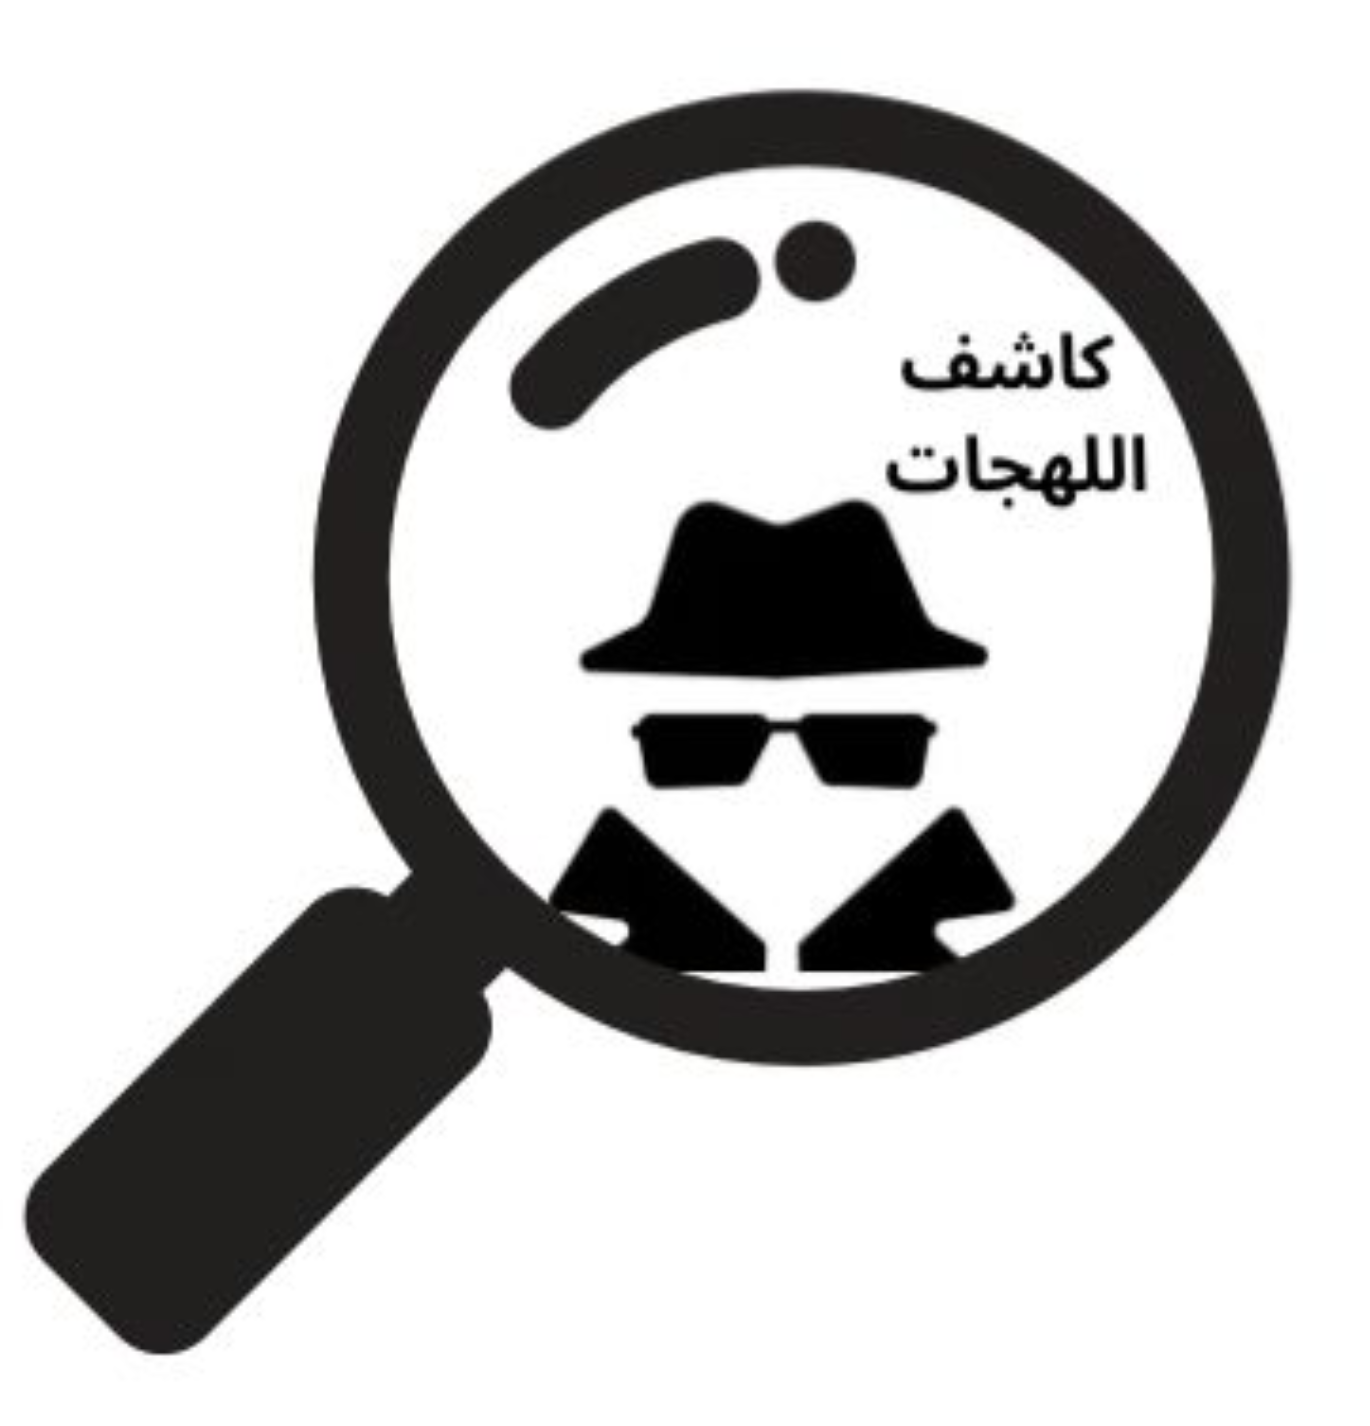

### **Installing the required libraries and preparing the dataset:**

In [ ]:
!pip install -U transformers datasets

In [ ]:
# Import the necessary libraries
import zipfile
import os
import pandas as pd
import glob
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
from torch import nn
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import transformers
from sklearn.utils import resample

In [ ]:
#Extract the files
zip_path='/content/MADAR.zip'
extract_file_path='/content/MADAR_Corpus'

with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall(extract_file_path)

In [ ]:
#Reading and merging files
tsv_files=glob.glob(extract_file_path + '/*.tsv')
# List to collect the files
All_data=[]
for file in tsv_files:
  Data=pd.read_csv(file,sep='\t')
  All_data.append(Data)

combined_data =pd.concat(All_data,ignore_index=True)

#Optional step:Save the new dataset as a CSV copy
combined_data.to_csv('/content/madar_combined.csv',index=False)

### **Dataset Exploration:**

In [ ]:
combined_data.shape

In [ ]:
combined_data.columns

In [ ]:
combined_data['sentID.BTEC'].unique()

In [ ]:
combined_data['split'].unique()

In [ ]:
combined_data['lang'].unique()

In [ ]:
num_dialects = combined_data['lang'].nunique()
print(num_dialects)

In [ ]:
combined_data['sent'].unique()

In [ ]:
num_of_dilect=combined_data['lang'].value_counts()
num_of_dilect

In [ ]:
num_of_dilect.plot(kind='bar')
plt.xlabel('Dialect')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Dialects in the Dataset')
plt.show()

### **Data Preprocessing:**

In [ ]:
#Delete unnecessary columns
combined_data = combined_data.drop(['sentID.BTEC', 'split'], axis=1)

In [ ]:
combined_data=combined_data[~combined_data['lang'].isin(['MSA', 'EN', 'FR', 'BEN'])]

In [ ]:
num_dialects = combined_data['lang'].nunique()
print(num_dialects)

In [ ]:
combined_data.isnull().sum()

In [ ]:
#Remove null values from the "sent" column
combined_data = combined_data.dropna(subset=['sent'])

In [ ]:
combined_data.isnull().sum()

In [ ]:
# Clean text by removing punctuations
arabic_punctuations='''؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ`'''
All_punct=string.punctuation + arabic_punctuations
combined_data['sent']=combined_data['sent'].apply(lambda x: ''.join([char for char in x if char not in All_punct]))

In [ ]:
combined_data['sent'].head()

In [ ]:
#Limit the number of words in the "sent" column
max_words=128

def truncate_sentence(sentence,max_len=max_words):
  words=sentence.split()
  if len(words) > max_len:
    return ' '.join(words[:max_len])
  else:
    return sentence
combined_data['sent']=combined_data['sent'].apply(truncate_sentence)

### **Split the dataset into train and test sets:**

*To bold text ensure that the training and testing sets maintain the same class distribution (i.e., balanced representation of each dialect), we use the stratify parameter when splitting the dataset

In [ ]:
x=combined_data['sent']
y=combined_data['lang']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
#Encode labels and create training and testing datasets
train_data=pd.DataFrame({'sent':x_train,'labels':y_train})
test_data=pd.DataFrame({'sent':x_test,'labels':y_test})

label_encoder=LabelEncoder()

train_data['labels'] = label_encoder.fit_transform(train_data['labels'])
test_data['labels'] = label_encoder.transform(test_data['labels'])

label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

print("Number of categories:", len(label2id))
print("Examples from label2id:", id2label)


train_dataset=Dataset.from_pandas(train_data)
test_dataset=Dataset.from_pandas(test_data)

In [ ]:
#Tokenization
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-mix")

def tokenize_fun(batch):
   return tokenizer(batch['sent'], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(tokenize_fun, batched=True, remove_columns=['sent'])
test_dataset  = test_dataset.map(tokenize_fun,  batched=True, remove_columns=['sent'])

### **Handle class imbalance with weighted loss:**

**In addition to upsampling, we incorporated a weighted loss during training. This gives higher importance to errors in underrepresented classes, helping the model learn from minority classes more effectively and preventing bias toward majority classes:**

In [ ]:
class_counts = np.bincount(train_data['labels'])
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float)

class CustomTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Get the labels from the inputs
        labels = inputs.get("labels").to(torch.long)
        # Forward pass through the model
        outputs = model(**{k: v for k, v in inputs.items() if k !="labels"})
        logits = outputs.get("logits")
        assert class_weights.numel() == model.config.num_labels, \
            f"class_weights({class_weights.numel()}) != num_labels({model.config.num_labels})"
        # Compute weighted loss using class weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        # Return loss (and outputs if requested)
        return (loss, outputs) if return_outputs else loss

### **Model Setup and Training:**

In [ ]:
#Load CAMeL BERT model configuration, tokenizer, and initialize the sequence classification model
config = AutoConfig.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-mix")
config.num_labels = 24

model = AutoModelForSequenceClassification.from_pretrained(
    "CAMeL-Lab/bert-base-arabic-camelbert-mix",
    config=config
)

In [ ]:
#Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    seed=42,
    fp16=torch.cuda.is_available()
)

In [ ]:
#Define metrics for model evaluation: accuracy, precision, recall, F1-score
def compute_metrics(eval_pred):
  logits,labels=eval_pred
  if isinstance(logits,tuple):
    logits=logits[0]
  preds = logits.argmax(axis=-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted',zero_division=0)
  acc=accuracy_score(labels,preds)
  return{
     'accuracy':acc,
     'Precision':precision,
     'Recall':recall,
     'F1':f1,
  }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_dir= "/content/drive/MyDrive/dialect_model"

os.makedirs(model_dir,exist_ok=True)

#Assign label mappings to model config and initialize CustomTrainer with datasets and metrics
model.config.id2label = id2label
model.config.label2id = label2id

if not os.path.exists(os.path.join(model_dir, "config.json")):
    print("No saved model found. Training...")
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)
else:
    print("Found saved model. Skipping training.")
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

In [ ]:
#Evaluate on test data
trainer.evaluate()

### **Interface Construction:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install gradio

In [ ]:


import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load saved model
model_dir = "/content/drive/MyDrive/dialect_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

id2label = model.config.id2label

label2ar = {
    "TUN": "تونسي", "CAI": "مصري (القاهرة)", "RAB": "مغربي (الرباط)",
    "DOH": "قطري (الدوحة)", "BEI": "لبناني (بيروت)", "ALE": "سوري (حلب)",
    "MUS": "عماني (مسقط)", "AMM": "أردني (عمان)", "DAM": "سوري (دمشق)",
    "JER": "فلسطيني (القدس)", "ASW": "مصري (أسوان)", "SFX": "ليبي (سرت)",
    "FES": "مغربي (فاس)", "BAS": "عراقي (البصرة)", "BAG": "عراقي (بغداد)",
    "SAL": "مغربي (سلا)", "JED": "سعودي (جدة)", "MOS": "عراقي (الموصل)",
    "TRI": "ليبي (طرابلس)", "KHA": "سوداني (الخرطوم)", "SAN": "يمني (صنعاء)",
    "RIY": "سعودي (الرياض)", "ALX": "مصري (الإسكندرية)", "ALG": "جزائري (الجزائر)"
}

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_id = torch.argmax(outputs.logits, dim=1).item()
    pred_label = id2label[pred_id]
    pred_ar = label2ar.get(pred_label, pred_label)
    return f"اللهجة المتوقعة: {pred_ar}"


logo_path = "/content/logo.png"


with gr.Blocks(theme="default") as demo:
    with gr.Row():
        gr.Image(logo_path, elem_id="logo", show_label=False, height=120)
    gr.Markdown("هذا النظام يعتمد على نموذج ذكاء اصطناعي مدرب لتحديد اللهجة العربية المكتوبة,فقط أدخل جملة أو كلمة")

    text_input = gr.Textbox(lines=3, placeholder="أدخل النص العربي هنا...")
    output = gr.Textbox(label="النتيجة")
    btn = gr.Button("اكشف")

    btn.click(predict, text_input, output)

demo.launch()
